In [3]:
import sys
import os
import geopandas as gpd
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.pardir)))

from VASA import VASA

In [2]:
help(VASA)

Help on class VASA in module VASA.preprocessing.vasa:

class VASA(builtins.object)
 |  VASA(df: 'str or pd.DataFrame', gdf: 'gpd.GeoDataFrame', df_group_col: 'str' = 'fips', gdf_group_col: 'str' = 'fips', date_col: 'str' = 'date', date_format: 'str' = '%Y-%m-%d', temp_res: "Literal[('day', 'week', 'month', 'year')]" = 'week') -> 'None'
 |  
 |  A standard data object for VASA plots
 |  
 |  
 |  Parameters
 |  ----------
 |  
 |  
 |  Attributes
 |  ----------
 |  
 |  
 |  Examples
 |  --------
 |  >>> import libpysal
 |  
 |  Methods defined here:
 |  
 |  __init__(self, df: 'str or pd.DataFrame', gdf: 'gpd.GeoDataFrame', df_group_col: 'str' = 'fips', gdf_group_col: 'str' = 'fips', date_col: 'str' = 'date', date_format: 'str' = '%Y-%m-%d', temp_res: "Literal[('day', 'week', 'month', 'year')]" = 'week') -> 'None'
 |      DOCSTRING
 |  
 |  get_county(self, fips: 'int', date='all') -> 'List[int]'
 |      # specify column...
 |  
 |  get_week(self, i: 'int') -> 'pd.DataFrame'
 |      # 

In [6]:

from VASA.preprocessing.prep import filter_data, filter_map, group_data, local_moran
from VASA.static_choropleth.static_choropleth import StackedChoropleth

mob_data = pd.read_csv("../data/all_minor_sources.csv")

# THIS CELL MAY NEED TO BE CHANGED

# Make sure this string matches the column name for the mobility values
# If you have multiple measures in your dataset, it's easiest if you just pick one
columns = [
    'sg_sheltered'
]

# Make sure this string matches the column name you have for the dates
date_col = "ds_m4"

# Make sure this string matches the column name you have for the county fips
fips_col = "fips"



# This is just used to put text on the plot, it doesn't really make what it says...
titles = [
    '% sheltered (Safegraph)'
]

mob_data = mob_data[["ds_m4", "fips", "sheltered_in_place_7days_rolling_avg"]]

# Read the map 
usa_map_data = pd.read_json("../data/counties.json")
usa_map = gpd.GeoDataFrame \
    .from_features(usa_map_data["features"]) \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")
usa_map = usa_map.assign(fips=[int(g) for g in usa_map["GEOID"]])
usa_map = filter_map(usa_map)

# Group the data into weeks
data = filter_data(mob_data, fips_col)
# grouped_usa = group_data(data, columns, date_col, fips_col, by="week")

In [95]:
data = data.loc[[str(d)[:4] == "2020" for d in data["ds_m4"]]]

In [136]:
"""
Utility Reducing Functions for VASA Object
-------------------------------------------------------

Three types:
    * Reducing by count:
        Adding up the total number of times the
        county attained some LISA classification.

    * Reducing by recency:
        The last week number of the time a county
        attained some LISA classification.

    * Reducing by mode:
        The most often LISA classification of a county.
"""

from typing import List, Tuple, Callable
from functools import reduce
import numpy as np
from scipy.stats import mode

HC_List = List[Tuple[int, int]]
County_History_List = List[List[int]]
County_list = List[int]


def reduce_by_count(arr: County_History_List) -> HC_List:

    # Start with pairs of 0 for each county
    initial: HC_List = [(0, 0) for _ in range(len(arr[0]))]

    reducer: Callable[[HC_List, List[int]], HC_List] = lambda acc, curr: [
        (a[0] + (c == 1), a[1] + (c == 2)) for a, c in zip(acc, curr)
    ]

    hh_ll: HC_List = reduce(
        reducer,
        arr,
        initial
    )

    return hh_ll


def reduce_by_count_hh(arr: County_History_List) -> County_list:
    return reduce_by_count_equals(arr, 1)


def reduce_by_count_ll(arr: County_History_List) -> County_list:
    return reduce_by_count_equals(arr, 2)


def reduce_by_count_equals(arr: County_History_List, val: int) -> County_list:
    return reduce(
        lambda acc, curr: np.array(acc) + (np.array(curr) == val),
        arr
    )


# ughhh this needs to be made better
# this should return a date for each classification....
def reduce_by_recency(arr: County_History_List) -> County_list:
    return [
        (hh if clas == 1 else (ll if clas == 2 else 0))
        for hh, ll, clas in zip(
            reduce_by_recency_hh(arr),
            reduce_by_recency_ll(arr),
            reduce_by_mode_sig(arr)
        )
    ]


def reduce_by_recency_hh(arr: County_History_List) -> County_list:
    return reduce_by_recency_equals(arr, 1)


def reduce_by_recency_ll(arr: County_History_List) -> County_list:
    return reduce_by_recency_equals(arr, 2)


def reduce_by_recency_equals(
    arr: County_History_List,
    val: int
) -> County_list:
    return [
        max([
            (idx if week[county_idx] == val else 0)
            for idx, week in enumerate(arr)
        ])
        for county_idx in range(len(arr[0]))
    ]


# not really mode b/c prefers sig over non-sig
# change to list for loop thingy
def reduce_by_mode_sig(arr: County_History_List) -> County_list:
    output: County_list = []

    for hh, ll in reduce_by_count(arr):
        region_class = 1 if hh > ll else 2
        output.append(region_class if max(hh, ll) > 0 else 0)

    return output


def reduce_by_mode(arr: County_History_List) -> County_list:
    return [
        mode([
            week[county_idx]
            for week in arr
        ])[0][0]  # argh
        for county_idx in range(len(arr[0]))
    ]


In [137]:
from __future__ import annotations
from typing import Literal, Tuple, Callable, List

import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as lps
from esda import Moran_Local

from functools import partial
# from concurrent import futures
from multiprocessing import cpu_count, Pool
from datetime import datetime as dt

# Commented out for testing...
# from .reduce_vasa_df import *


class VASA:
    """
    A standard data object for VASA plots


    Parameters
    ----------


    Attributes
    ----------


    Examples
    --------
    >>> import libpysal


    """
    def __init__(
        self,
        df: str or pd.DataFrame,
        gdf: gpd.GeoDataFrame,
        df_group_col: str = "fips",
        gdf_group_col: str = "fips",
        date_col: str = "date",
        date_format: str = "%Y-%m-%d",
        temp_res: Literal["day", "week", "month", "year"] = "week"
    ) -> None:
        """
            DOCSTRING
        """
        if isinstance(df, str):
            df = pd.read_csv(df)
        elif not isinstance(df, pd.DataFrame):
            raise Exception("Data not of proper type")

        self.df = df.copy()
        self.df_group_col = df_group_col
        self.gdf = gdf
        self.gdf_group_col = gdf_group_col
        self.date_col = date_col
        self.date_format = date_format
        self.temp_res = temp_res

        self.cols: List[str] = list(
            {*df.columns} - {self.df_group_col, self.date_col}
        )

        # Convert date column to dates
        if isinstance(self.df[self.date_col].dtypes, object):
            self.df[self.date_col] = self.df[self.date_col].apply(
                lambda x: dt.strptime(x, self.date_format).date()
            )
        # NUMPY DATES ??

        # self.group()

    # WE NEED TO CHECK IF THERE IS ONLY ONE GROUP.
    # IF WE ONLY HAVE DATES Jan 1-6, Are these always grouped together?
    def group(self) -> None:
        # pass in functions other than mean
        agg_dict = dict(zip(
            [*self.cols, self.date_col],
            [*np.repeat(np.nanmean, len(self.cols)), "min"]
        ))

        if self.temp_res == "day":
            # assign year_month_day
            grouped = self.df
        elif self.temp_res == "week":
            year_week = [
                get_year_week(date)
                for date in self.df[self.date_col]
            ]

            grouped = self.df \
                .assign(
                    year_week=year_week
                ) \
                .groupby(["year_week", self.df_group_col]) \
                .agg(agg_dict) \
                .reset_index() \
                .groupby(["year_week"])

        elif self.temp_res == "month":
            # assign year_month
            grouped = self.df
        elif self.temp_res == "year":
            # assign year
            grouped = self.df
        else:
            raise Exception("Incorrect temporal resolution")

        # this is going to have to be based on the map or something
        output = pd.DataFrame()
        for _, group in grouped:
            ordered = pd.merge(
                self.gdf, group,
                left_on=self.gdf_group_col, right_on=self.df_group_col,
                how='left'
            )

            output = output.append({
                "date": ordered.loc[0, self.date_col],
                **{c: ordered[c] for c in self.cols}
            }, ignore_index=True)

        self.fips_order = ordered[self.gdf_group_col]
        self.df = output
        # return (output, ordered[self.gdf_group_col])

    # specify column...
    def get_county(self, fips: int, date="all") -> List[int]:
        i = list(self.fips_order).index(fips)
        return [row[self.cols[0]][i] for _, row in self.df.iterrows()]

    # df / list idk, specify columns
    def get_week(self, i: int) -> pd.DataFrame:
        return self.df.loc[i, self.cols[0]]

    def save_output(self, date, fips, vars):
        return 1

    def lisa(self) -> None:
        num_processes = cpu_count()

        W = lps.weights.Queen(self.gdf["geometry"])
        W.transform = 'r'

        with Pool(num_processes) as pool:
            self.df[self.cols[0]] = list(
                pool.map(
                    partial(func, col=self.cols[0],
                            W=W, sig=0.05, which="fdr"),
                    [row for _, row in self.df.iterrows()]
                )
            )

    def reduce(
        self,
        # this could return anything really...
        reduce: (
            Literal["count", "recency", "count_hh", "count_ll", "mode"] |
            Callable[[List[List[int]]], List[int]]
        )
    ) -> pd.DataFrame:
        copy: pd.DataFrame = self.df[self.cols].copy()

        if reduce == "count":
            reduce = reduce_by_count
        elif reduce == "count_hh":
            reduce = reduce_by_count_hh
        elif reduce == "count_ll":
            reduce = reduce_by_count_ll
        elif reduce == "recency":
            reduce = reduce_by_recency
        elif reduce == "mode_sig":
            reduce = reduce_by_mode_sig
        elif reduce == "mode":
            reduce = reduce_by_mode

        return copy \
            .agg(reduce) \
            .assign(fips=self.fips_order)

    # I want to change the name of this
    def agg(self, ag):
        return 1


def func(ordered, col, W, sig, which):
    return moran_quadrants(ordered[col], W, sig, which=which)

# esda fdr is not strictly doing fdr


def false_discovery_rate(arr, sig):
    df = pd.DataFrame(arr, columns=["p"]).sort_values("p")
    df["i"] = np.arange(1, len(arr) + 1) * sig / len(arr)
    df["sig"] = df["p"] < df["i"]
    return list(df.sort_index()["sig"])


def bonferroni(arr, sig):
    return list(np.array(arr) < sig / len(arr))


# We don't want to filter
def filter_quadrants(arr):
    return [(a if a < 3 else a) for a in arr]


# this needs to change if we don't filter
def combine(sim, fdr, bon):
    return [
        (b + 4 if b != 0 else (f + 2 if f != 0 else s))
        for b, f, s in zip(bon, fdr, sim)
    ]

#
#
#
#
#

#
# This function runs the local moran test for us and returns an array of
# the quadrant classification for each county
#
#


#
# STILL GET THE ISSUE WHERE VERYTHING IS A 2 
#
def moran_quadrants(col, W, alpha, which):
    local_moran = Moran_Local(col, W, geoda_quads=True,
                              permutations=n_permutations(col))

    ps = local_moran.p_sim
    qs = filter_quadrants(local_moran.q)

    if which == "fdr":
        f = false_discovery_rate(ps, alpha)
    elif which == "sim":
        f = [p < alpha for p in ps]
    elif which == "bon":
        f = bonferroni(ps, alpha)
    elif which == "all":
        fdr = false_discovery_rate(ps, alpha)
        bon = bonferroni(ps, alpha)
        sim = [p < alpha for p in ps]

        qs = combine(
            qs * np.array(sim),
            qs * np.array(fdr),
            qs * np.array(bon)
        )
        f = sim
    else:
        raise 'Valid p-value evaluations: "bon", "fdr", or "sim"'

    return list(qs * np.array(f))


def n_permutations(df):
    return 999  # default value


def get_year_week(date: dt) -> Tuple[int, int]:
    """
    get_year_week [summary]

    Args:
        date (dt): [description]

    Returns:
        Tuple[int, int]: [description]
    """
    week_num = date.isocalendar()[1]
    year = date.year

    if week_num == 1 and date.month == 12:
        year += 1
    elif week_num == 53 and date.month == 1:
        year -= 1

    # Year comes first so dataframe is sorted chronologically
    return (year, week_num)


In [138]:
v = VASA(data, usa_map, date_col="ds_m4")
v.group()
v.lisa()

In [99]:
for i, row in v.df.iterrows():
    print(row["sheltered_in_place_7days_rolling_avg"][0])

0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0


In [184]:
def scatterplot(v):

    count = v.reduce("count")
    recent = v.reduce('recency')

    df = count.merge(recent, left_on="fips", right_on="fips", how="inner", suffixes=("_count","_recency"))
    df["count"] = [max(c) for c in df["sheltered_in_place_7days_rolling_avg_count"]]
    df["which"] = [(1 if h > c else 0) for h, c in df["sheltered_in_place_7days_rolling_avg_count"]]

    df = df.rename({ "sheltered_in_place_7days_rolling_avg_recency": "recent" }, axis="columns")

    print(df)

    points = df[["count", "recent", "which"]].groupby(["count", "recent"]).agg(np.mean)

    print(points)

    fig, axes = plt.subplots(
        1,
        1,
        figsize=(8, 8)
    )
    fig.tight_layout()

    create_scatter(axes, points)


def create_scatter(ax, df):
    #ax.scatter(xs, ys, c="blue", alpha=0.3)
    sns.scatterplot(x="recent", y="count", data=df, hue="which", palette="bwr", ax=ax)
    # slope = 1 line
    # ax.plot(range(0, max(xs) + 1), range(0, max(xs) + 1))

In [181]:
v.reduce("count")

,sheltered_in_place_7days_rolling_avg,fips
0,"(6, 0)",6075
1,"(20, 1)",25025
2,"(0, 1)",31007
3,"(0, 1)",37181
4,"(0, 36)",48421
...,...,...
3100,"(25, 1)",32005
3101,"(0, 5)",29163
3102,"(0, 4)",19079
3103,"(0, 19)",19027


     sheltered_in_place_7days_rolling_avg_count   fips  recent  count  which
0                                        (6, 0)   6075      40      6      1
1                                       (20, 1)  25025      51     20      1
2                                        (0, 1)  31007      52      1      0
3                                        (0, 1)  37181      52      1      0
4                                       (0, 36)  48421      52     36      0
...                                         ...    ...     ...    ...    ...
3100                                    (25, 1)  32005      50     25      1
3101                                     (0, 5)  29163      52      5      0
3102                                     (0, 4)  19079      52      4      0
3103                                    (0, 19)  19027      52     19      0
3104                                     (0, 1)  13073      52      1      0

[3105 rows x 5 columns]
              which
count recent       
0     0    

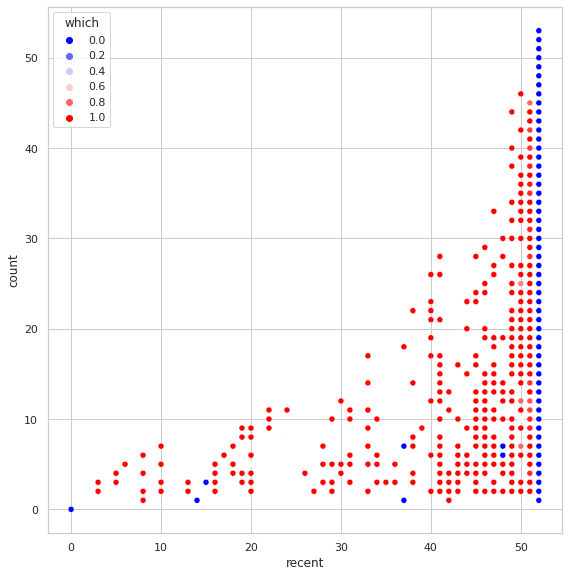

In [188]:
scatterplot(v)

In [217]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# This is not going to be front facing
# // don't need docs/doc string
# but genearl stuff would be nice

# Probably need to double check the typing here
#
# import matplotlib as mpl
# mpl.axes._subplots.AxesSubplot
# mpl.figure.Figure


class BasePlot:

    def __init__(
        self,
        fig: mpl.figure.Figure,
        folder: str
    ) -> None:
        self.fig = fig
        self.folder = folder

        if not os.path.exists(f"{folder}/"):
            os.makedirs(f"{folder}/")

    def save_plot(
        self, name: str,
        file_ext: str = "png",
        dpi: int = 150,
        subfolder: str = "",
        override: bool = False
    ):
        output = f"{self.folder + ('/' if subfolder else '') + subfolder}/"
        if not os.path.exists(f"{output}/"):
            os.makedirs(f"{output}/")

        file_name = f"{output}/{name}.{file_ext}"

        if not override:
            i = 0
            while os.path.isfile(file_name):
                i += 1
                file_name = f"{output}/{name} ({i}).{file_ext}"

        self.fig.set_facecolor("w")
        self.fig.tight_layout()
        self.fig.savefig(
            file_name,
            bbox_inches='tight',
            dpi=dpi
        )

    def hide_axis(self, ax: plt.Axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)


In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
# from ..BasePlot import BasePlot


class Scatter(BasePlot):

    def __init__(self, v):
        fig, axes = plt.subplots(
            1,
            1,
            figsize=(8, 8)
        )
        super().__init__(fig, "scatter_test")

        self.v = v
        self.fig = fig
        self.axes = [axes] # axes.flatten()
        self.plotted = False

    def plot(self):
        count = self.v.reduce("count")
        recent = self.v.reduce('recency')

        df = count.merge(recent, left_on="fips", right_on="fips", how="inner", suffixes=("_count","_recency"))
        df["count"] = [max(c) for c in df["sheltered_in_place_7days_rolling_avg_count"]]
        df["which"] = [(1 if h > c else 0) for h, c in df["sheltered_in_place_7days_rolling_avg_count"]]

        df = df.rename({ "sheltered_in_place_7days_rolling_avg_recency": "recent" }, axis="columns")

        print(df)

        points = df.groupby(["count", "recent"]).agg(np.mean)

        print(points)
        
        for i, ax in enumerate(self.axes):

            # fig.tight_layout()

            self.__create_scatter(ax, points)

        self.plotted = True
        return self.fig

    def __create_scatter(self, ax, df):
        sns.scatterplot(x="recent", y="count", data=df, hue="which", palette="bwr", ax=ax)


    def save_plot(self, *args, **kwargs):
        if not self.plotted:
            return

        super().save_plot(*args, **kwargs)
    # def create_scatter(ax, df):
    #     #ax.scatter(xs, ys, c="blue", alpha=0.3)
    #     sns.scatterplot(x="recent", y="count", data=df, hue="which", palette="bwr", ax=ax)
    #     # slope = 1 line
    #     # ax.plot(range(0, max(xs) + 1), range(0, max(xs) + 1))


    # def create_scatter(ax, df):
    #     #ax.scatter(xs, ys, c="blue", alpha=0.3)
    #     sns.scatterplot(x="recent", y="count", data=df, hue="which", palette="icefire", ax=ax)
    #     # slope = 1 line
    #     # ax.plot(range(0, max(xs) + 1), range(0, max(xs) + 1))

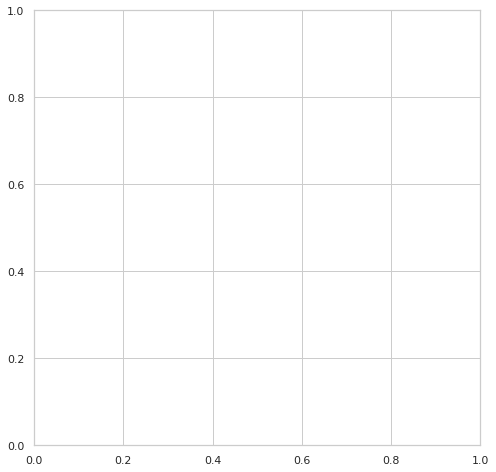

In [233]:
scatplt = Scatter(v)

     sheltered_in_place_7days_rolling_avg_count   fips  recent  count  which
0                                        (6, 0)   6075      40      6      1
1                                       (20, 1)  25025      51     20      1
2                                        (0, 1)  31007      52      1      0
3                                        (0, 1)  37181      52      1      0
4                                       (0, 36)  48421      52     36      0
...                                         ...    ...     ...    ...    ...
3100                                    (25, 1)  32005      50     25      1
3101                                     (0, 5)  29163      52      5      0
3102                                     (0, 4)  19079      52      4      0
3103                                    (0, 19)  19027      52     19      0
3104                                     (0, 1)  13073      52      1      0

[3105 rows x 5 columns]
                      fips  which
count recent     

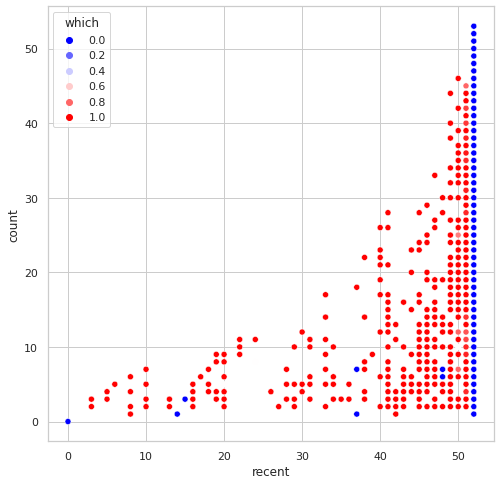

In [235]:
scatplt.plot()

In [236]:
scatplt.save_plot("test1")

In [145]:

# add state names
state_names = pd.read_html('https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code')
print(len(state_names))

state_names = state_names[0]

state_names.columns = ['name', 'letter_abbr', 'num_code', 'stat']

state_names.drop('stat', axis=1, inplace=True)

state_names.num_code = state_names.num_code.apply(lambda x: '0' + str(x) if len(str(x))==1 else str(x))

state_names.head()

state_names.loc[state_names.num_code=='25']

5


,name,letter_abbr,num_code
33,Massachusetts,MA,25


In [242]:
# # add state names
# state_names = pd.read_html('https://en.wikipedia.org/wiki/Federal_Information_Processing_Standard_state_code')
# print(len(state_names))

# state_names = state_names[0]

# state_names.columns = ['name', 'letter_abbr', 'num_code', 'stat']

# state_names.drop('stat', axis=1, inplace=True)

# state_names.num_code = state_names.num_code.apply(lambda x: '0' + str(x) if len(str(x))==1 else str(x))

# state_names.head()

# state_names.loc[state_names.num_code=='25']

import matplotlib.pyplot as plt

from VASA.preprocessing.vasa import VASA
from VASA.BasePlot import BasePlot


class Strip(BasePlot):

    def __init__(self, v: VASA, cols=None):
        # fig, axes = plt.subplots(
        #     1,
        #     1,
        #     figsize=(8, 8)
        # )
        super().__init__(None, "scatter_test")

        #self.fig = fig
        #self.axes = [axes]
        self.v = v

    def plot(self):
        ndf = self.v.reduce("mode")
        ndf['state_num'] = [str(f // 1000) for f in ndf.fips] #.str.slice(start=0, stop=2)
        ndf['state_num'] = [("0" + str(f//1000) if f//1000 < 10 else str(f//1000)) for f in ndf.fips]
        ndf = pd.merge(ndf, state_names, how='left', left_on='state_num', right_on='num_code')

        counties_per_state = ndf.groupby(['fips','letter_abbr'])\
            .size()\
            .reset_index()\
            .rename(columns={0:'count'})\
            .groupby('letter_abbr')['fips']\
            .size()\
            .reset_index()

        check1 = usa_map.groupby('STATEFP').size().reset_index().set_index("STATEFP").sort_index()

        check2 = ndf.groupby(['fips','num_code'])\
            .size()\
            .reset_index()\
            .rename(columns={0:'count'})\
            .groupby('num_code')['fips']\
            .size()\
            .reset_index()\
            .set_index('num_code')\
            .sort_index()

        #gdf.head()

        check1.columns = ['cnt']

        # print(counties_per_state)

        moder = ndf.loc[ndf[v.cols].sum(axis=1)>0,]
        lst_row = []

        for i in v.cols: 
            g = moder[['letter_abbr', i]].groupby(['letter_abbr', i]).size().reset_index()
            g['source'] = i
            g.columns = ['letter_abbr', 'val', 'count', 'source'] 
            lst_row.append(g)

        cc = pd.concat(lst_row) 
        cc = cc.loc[cc.val!=0,]

        ppiv = cc.pivot(index=['letter_abbr', 'val'], columns='source', values='count')
        ppiv = ppiv.reset_index()
        ppiv = ppiv[['letter_abbr', 'val', 'sheltered_in_place_7days_rolling_avg']]


        msc = pd.merge(check1, state_names, left_on='STATEFP', right_on='num_code')
        ppiv = pd.merge(ppiv, msc, how='left', on='letter_abbr')

        ppiv.loc[:, 2:3] = ppiv.iloc[:,2:3].div(ppiv.cnt, axis=0)*100
        ppiv.loc[:, 2:3] = ppiv.iloc[:,2:3].apply(lambda x: round(x,1))

        #
        #
        #   PLOT
        #
        #

        sns.set_theme(style="whitegrid")
        #open_circle = mpl.path.Path(vert)

        text_style = dict(horizontalalignment='right', verticalalignment='center',
                        fontsize=12, fontfamily='monospace')

        # Load the dataset
        #crashes = sns.load_dataset("car_crashes")

        # Make the PairGrid
        g = sns.PairGrid(ppiv,
                        x_vars=ppiv.columns[2:3], y_vars=["letter_abbr"], hue='val',
                        height=10, aspect=.25, palette=['red', 'blue'])

        # Draw a dot plot using the stripplot function
        g.map(sns.stripplot, size=10, orient="h", jitter=False, alpha=.65, linewidth=1) #marker=r"$\circ$")#, alpha=0.5)

        # Use the same x axis limits on all columns and add better labels
        g.set(xlim=(-5, 105), xlabel="", ylabel="")

        # Use semantically meaningful titles for the columns
        titles = ['SafeGraph \nmedian distance traveled']

        for ax, title in zip(g.axes.flat, titles):

            # Set a different title for each axes
            ax.set(title=title)

            # Make the grid horizontal instead of vertical
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)

        sns.despine(left=True, bottom=True)

        fig = plt.gcf()
        self.fig = fig

        fig.text(0.5, 0.02, '% of counties classified as hotspot / coldspot', ha='center')

        # fig.savefig('images/strip_plot_v2.jpeg', dpi=150, bbox_inches='tight')


In [243]:
strp = Strip(v)

<ipython-input-242-52a298362490>:89: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ppiv.loc[:, 2:3] = ppiv.iloc[:,2:3].div(ppiv.cnt, axis=0)*100
<ipython-input-242-52a298362490>:90: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ppiv.loc[:, 2:3] = ppiv.iloc[:,2:3].apply(lambda x: round(x,1))


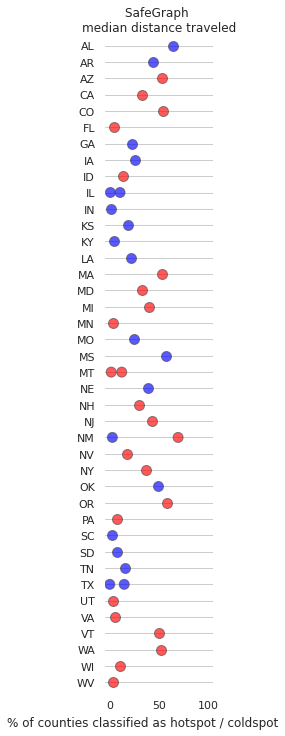

In [244]:
strp.plot()

In [186]:

def summary(v):
    df = v.reduce("mode")

    print(df)

In [187]:
summary(v)

      sheltered_in_place_7days_rolling_avg   fips
0                                        0   6075
1                                        0  25025
2                                        0  31007
3                                        0  37181
4                                        2  48421
...                                    ...    ...
3100                                     0  32005
3101                                     0  29163
3102                                     0  19079
3103                                     0  19027
3104                                     0  13073

[3105 rows x 2 columns]
